# **Análise do mercado de venda de carros**

Realização do projeto: André Dambry



---



O objetivo desse projeto é analisar um site de venda de carros tanto novos quanto usados

No caso, o projeto vai ser baseado nos dados obtidos no site [Kavak](https://www.kavak.com/br/carros-usados), onde será feito um Web Scrapping para obter informações relevantes

O projeto vai ser dividido em 3 seções, sendo elas:

1.   Aquisição e limpeza dos dados
2.   Análise dos dados
3.   Conclusão

O resultado final esperado é de encontrar, a partir dos dados obtidos no site, qual seria o carro mais rentável para a revenda, ou seja, qual seria o carro com o maior valor e também com o maior número de anúncios



---



## **Preparação do ambiente**

Esse passo foi feito devido à problemas de execução do driver do Selenium

In [ ]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

Executing: /tmp/apt-key-gpghome.PlzHRxSrzh/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.PdwQEyaI75/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.YPdoyDFFXB/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
gpg: cannot open '/dev/tty': No such device or address
gpg: [stdout]: write error: Broken pipe
gpg: filter_flush failed on c

## **Import de bibliotecas**

In [ ]:
import os
import requests
import bs4
from bs4 import BeautifulSoup
import sys
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import IPython
import itertools
import numpy as np
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By



 ---



# **1. Aquisição e limpeza dos dados**

Foi utilizado a biblioteca Selenium para utilizar o driver e percorrer o dado adquirindo os dados. Foi feito a iteração em diversas páginas do site para obter a maior quantidade de dados.

Os dados obtidos foram, o nome do veículo, o seu preço e o detalhamento (Ano do carro, Km rodado e cidade da venda)

## 1.1 Definição dos parâmetros do driver

In [ ]:
user_agents_list = [
    'Mozilla/5.0 (iPad; CPU OS 12_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.83 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36'
]

options = Options()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument('--disable-blink-features=AutomationControlled')
options.headless = True

user_agent = {'User-Agent': random.choice(user_agents_list)}

options.add_argument('user-agent={0}'.format(user_agent))

<ipython-input-8-bd808b57def0>:11: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  options.headless = True


## 1.2 Execução do driver e aquisição dos dados

Para a aquisição dos dados, foi utilizado o Webdriver para percorrer e adquirir os dados mencionados. Então ele percorre pelas páginas definidas pela variável "n_pgs" (foi definido 89 como o padrão pois há 88 páginas no momento que foi feito o projeto)


In [ ]:
lista_nome = []
lista_preco = []
lista_detalhe = []

teste = []

driver = webdriver.Chrome("/usr/bin/chromedriver", options=options)

n_pgs = 89

start = time.time()

for page in range(1,n_pgs,1):

  t = page

  time.sleep(1)

  page_url = "https://www.kavak.com/br/page-"+str(page)+"/carros-usados"
  driver.get(page_url)
  driver.implicitly_wait(10)

  soup = BeautifulSoup(driver.page_source, 'html.parser')

  Nome = soup.find_all('h2', class_='car-name')
  Preco = soup.find_all('span', class_="payment-total payment-highlight")
  Detalhe = soup.find_all('p', class_='car-details')

  for i in range(len(Nome)):
          lista_nome.append(Nome[i].text)
          lista_preco.append(Preco[i].text)
          lista_detalhe.append(Detalhe[i].text)

et = time.time() - start

print(f'\nTotal de páginas carregadas:{page}\nTotal de dados carregados:{len(lista_nome)}\n')
print("Tempo total de execução: {:.2f} minutos".format(et / 60))
driver.quit()

<ipython-input-9-92ca55bb56b1>:7: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome("/usr/bin/chromedriver", options=options)



Total de páginas carregadas:88
Total de dados carregados:3125

Tempo total de execução: 11.28 minutos


## 1.3 Armazenamento em um DataFrame da biblioteca Pandas

In [ ]:
df = pd.DataFrame({'Nome': lista_nome,
                   'Preço': lista_preco,
                   'Detalhamento': lista_detalhe
                  })

In [ ]:
#Foram identificados alguns outliers específicos que iriam atrapalhar na manipulação, por isso foi feito esse replace específico
df = df.replace(regex={r'Mercedes Benz': 'Mercedes-Benz','Land Rover': 'Land-Rover', 'Range Rover': 'Range-Rover'})
df

,Nome,Preço,Detalhamento
0,Hyundai HB20S EVOLUTION MANUAL,R$ 77.599,2022 • 19.140 km • São Paulo
1,Citroën C3 EXCLUSIVE,R$ 58.499,2017 • 61.754 km • São Paulo
2,Fiat Cronos E.TORQ PRECISION,R$ 73.599,2019 • 51.089 km • São Paulo
3,Ford Focus SE PLUS,R$ 62.299,2016 • 78.571 km • São Paulo
4,Toyota Yaris XL MULTIDRIVE,R$ 78.099,2019 • 71.286 km • São Paulo
...,...,...,...
3120,Audi Q5 TFSI AMBIENTE,R$ 105.299,2015 • 92.472 km • São Paulo
3121,Fiat Palio MPI FIRE,R$ 30.499,2015 • 79.475 km • São Paulo
3122,Chery Tiggo 5x VVT TURBO i TXS DCT,R$ 102.999,2020 • 16.400 km • São Paulo
3123,Volkswagen Voyage MSI TOTAL,R$ 54.599,2019 • 40.543 km • São Paulo


## 1.4 Manipulação dos dados

Analisando o DataFrame, é possível observar que é necessário realizar manipulações para conseguir analisá-los.

No caso, as seguintes manipulações serão feitas:

1.   Coluna Nome: Separar o nome, a marca e modelo do carro
2.   Coluna Detalhamento: Separar o ano do modelo, Km rodados e cidade da venda
3.   Coluna Preço: Transformar em número
4.   Junção das bases manipuladas




### 1.4.1 Manipilação coluna Nome

In [ ]:
df['Lista'] = list(df.Nome.str.split())

def separar_lista(row):
    return pd.Series([row['Lista'][0], row['Lista'][1], ' '.join(row['Lista'][2:])])

df_carro = df.apply(separar_lista, axis=1)

df_carro.columns = ['Marca', 'Carro', 'Modelo']

df_carro

,Marca,Carro,Modelo
0,Hyundai,HB20S,EVOLUTION MANUAL
1,Citroën,C3,EXCLUSIVE
2,Fiat,Cronos,E.TORQ PRECISION
3,Ford,Focus,SE PLUS
4,Toyota,Yaris,XL MULTIDRIVE
...,...,...,...
3120,Audi,Q5,TFSI AMBIENTE
3121,Fiat,Palio,MPI FIRE
3122,Chery,Tiggo,5x VVT TURBO i TXS DCT
3123,Volkswagen,Voyage,MSI TOTAL


### 1.4.2 Manipulação coluna Detalhamento


In [ ]:
df_det=df['Detalhamento'].str.split(pat='•', expand=True)

df_det.columns = ['Ano', 'Km rodados', 'Cidade do vendedor']

df_det['Km rodados'] = df_det['Km rodados'].str.replace(r'km', '')

df_det

,Ano,Km rodados,Cidade do vendedor
0,2022,19.140,São Paulo
1,2017,61.754,São Paulo
2,2019,51.089,São Paulo
3,2016,78.571,São Paulo
4,2019,71.286,São Paulo
...,...,...,...
3120,2015,92.472,São Paulo
3121,2015,79.475,São Paulo
3122,2020,16.400,São Paulo
3123,2019,40.543,São Paulo


### 1.4.3 Manipulação coluna Preço


In [ ]:
df_preco = df['Preço'].str.replace(r'R\$','')
df_preco = df_preco.str.strip()
df_preco = pd.to_numeric(df_preco, errors='coerce')
df_preco

<ipython-input-15-79531d5dfb7f>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_preco = df['Preço'].str.replace(r'R\$','')


0        77.599
1        58.499
2        73.599
3        62.299
4        78.099
         ...   
3120    105.299
3121     30.499
3122    102.999
3123     54.599
3124     39.999
Name: Preço, Length: 3125, dtype: float64

### 1.4.4 Junção das bases

In [ ]:
df = pd.concat([df_carro, df_preco, df_det],axis = 1)
df

,Marca,Carro,Modelo,Preço,Ano,Km rodados,Cidade do vendedor
0,Hyundai,HB20S,EVOLUTION MANUAL,77.599,2022,19.140,São Paulo
1,Citroën,C3,EXCLUSIVE,58.499,2017,61.754,São Paulo
2,Fiat,Cronos,E.TORQ PRECISION,73.599,2019,51.089,São Paulo
3,Ford,Focus,SE PLUS,62.299,2016,78.571,São Paulo
4,Toyota,Yaris,XL MULTIDRIVE,78.099,2019,71.286,São Paulo
...,...,...,...,...,...,...,...
3120,Audi,Q5,TFSI AMBIENTE,105.299,2015,92.472,São Paulo
3121,Fiat,Palio,MPI FIRE,30.499,2015,79.475,São Paulo
3122,Chery,Tiggo,5x VVT TURBO i TXS DCT,102.999,2020,16.400,São Paulo
3123,Volkswagen,Voyage,MSI TOTAL,54.599,2019,40.543,São Paulo


Com isso, se tem a base manipulada para realizar as análises



---



# **2. Análise dos dados**

Nessa seção serão feitas as análises necessárias para responder a pergunta motivadora desse projeto, que seria: "*Qual o carro mais rentável para revenda?*"



Antes de realizar as análises, serão consideradas algumas premissas com o intuito de simplificar a análise com os dados adquiridos

1. Os dados adquiridos na KAVAK refletem o estado geral do mercado de venda e revenda de veículos
2. Os preços extraidos serão considerados os preços iniciais do anúncio
3. A quantidade de anúncios no site representa a maior quantidade de demanda de um certo carro



## 2.1 Contagem de anúncios por carro
Foi feita a contagem de cada anúncio de carro e criada uma coluna com a porcentagem acumulada à partir número da contagem, assim foi pego os carros que representam 25% da base de dados

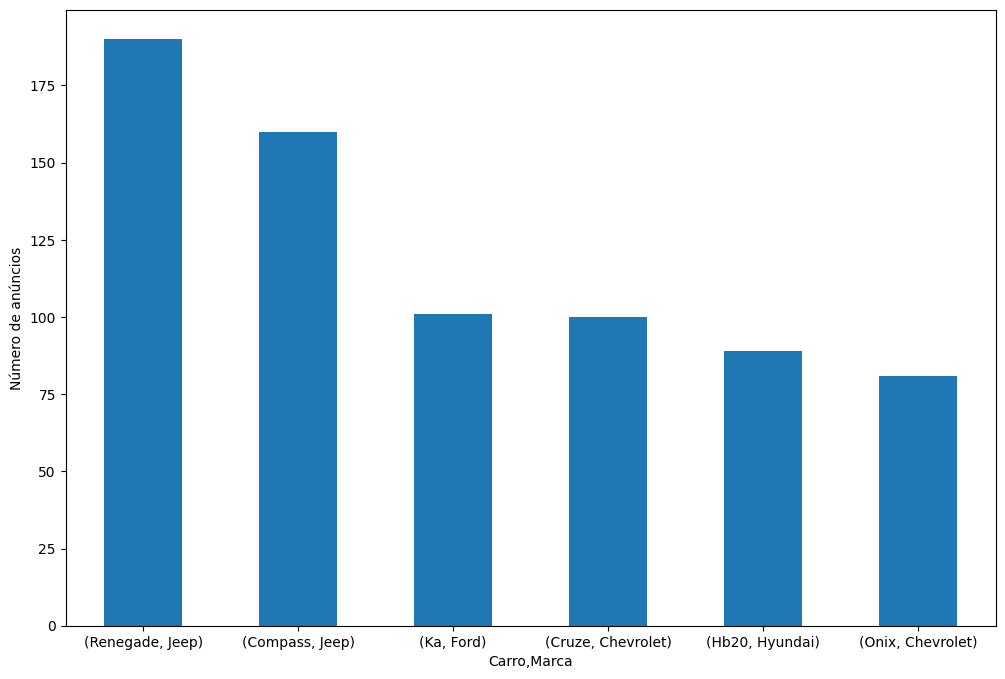

In [ ]:
df_count_car_all = df.groupby(['Carro', 'Marca']).count()

df_count_car_all= df_count_car_all.sort_values('Modelo', ascending = False)

df_count_car_all['acu'] = 100 * (df_count_car_all['Modelo'].cumsum()/df_count_car_all['Modelo'].sum()) #Coluna de percentual acumulado

df_count_car = df_count_car_all[df_count_car_all['acu'] <= 25] #Dataframe com os 25% mais relevantes de acordo com a quantidade de anúncios

ax = df_count_car.Modelo.plot.bar(ylabel = 'Número de anúncios',rot=0, fontsize = 10, figsize = [12,8])

Com isso, é visto que o Renegade e Compass são os carros que apresentam a maior quantidade de anúncios, ambos da marca Jeep.

## 2.2 Contagem de anúncios por marca
Visto que os dois carros que apresentam a maior quantidade de anúncios são da mesma marca, é feito a mesma análise, porém com o agrupamento por marca

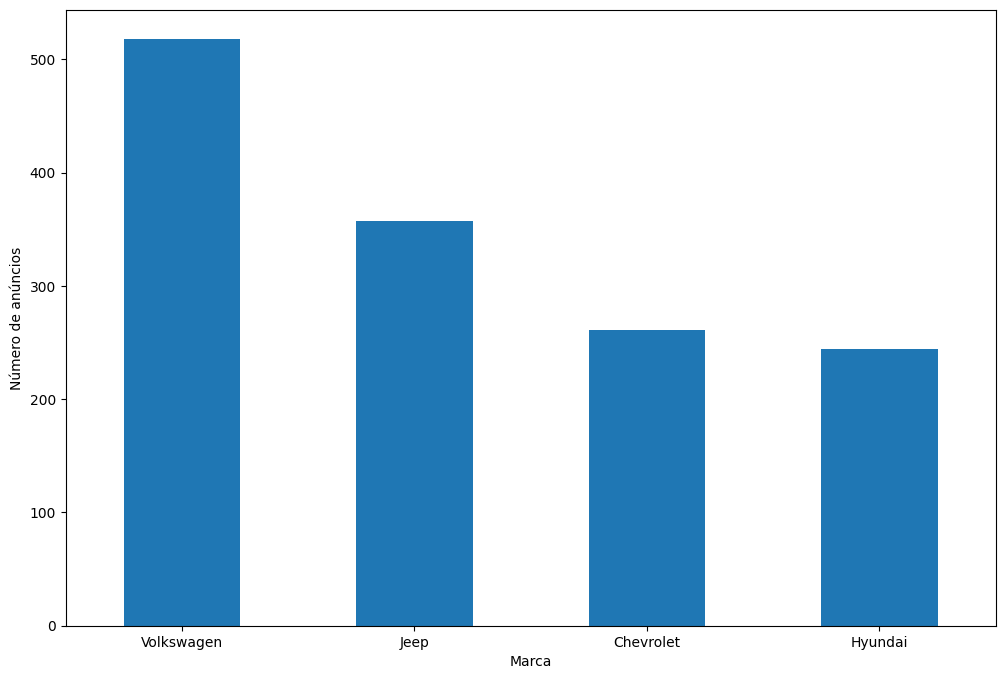

In [ ]:
df_inter2 = df.groupby(['Marca']).count()

df_inter2 = df_inter2.sort_values('Modelo', ascending = False)

df_inter2['acu'] = 100 * (df_inter2['Modelo'].cumsum()/df_inter2['Modelo'].sum()) #Coluna de percentual acumulado

df_count_brand = df_inter2[df_inter2['acu'] <= 50] #Dataframe com os 50% mais relevantes de acordo com a quantidade de anúncios

ax = df_count_brand.Modelo.plot.bar(ylabel = 'Número de anúncios',rot=0, fontsize = 10, figsize = [12,8])

Observando o gráfico é visto que a marca Jeep é o segundo com mais anúncios, sendo a primeira a marca Volkswagen.

Com isso, pode-se levantar a hipótese que é por conta da variedade de carros que essa marca apresenta.

## 2.3 Contagem de anúncios de carros por marca
Essa análise vai ser feita para validar a hipótese levantada na última seção, de que a marca do carro que apresenta a maior quantidade de anúncios se difere da quantidade de anúncios de uma marca por conta da maior variedade de carros da marca.

Vão ser escolhidas as marcas mais relevantes de acordo com a última seção.

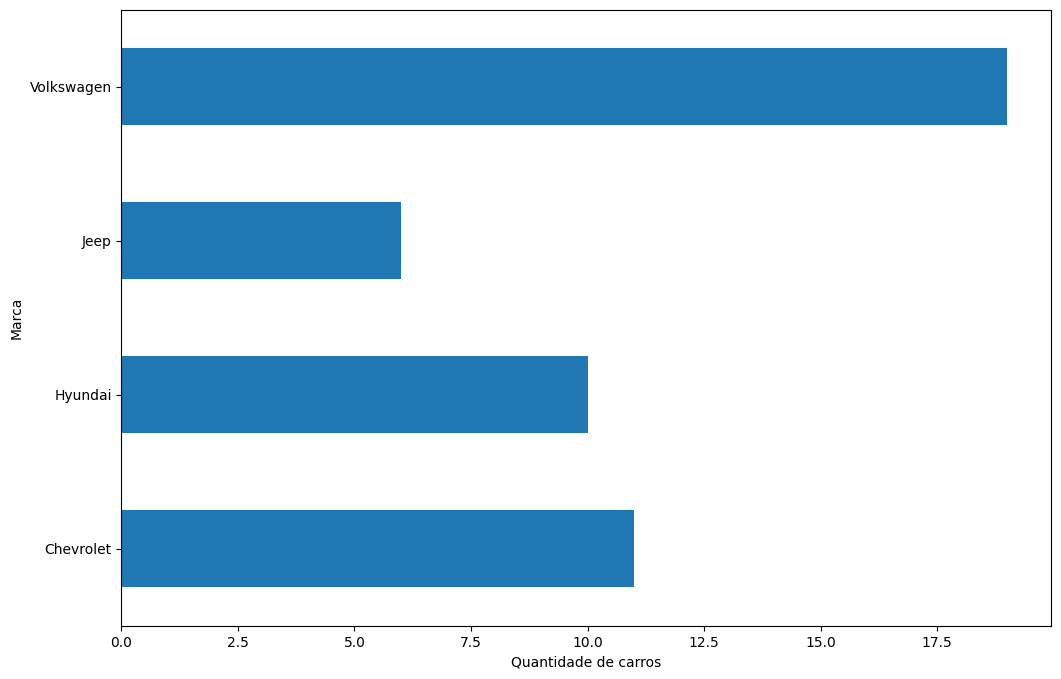

In [ ]:
df_carro_marca = df[df['Marca'].isin(list(df_count_brand.index))]
df_quant_carro = df_carro_marca.groupby(['Marca']).nunique()
ax = df_quant_carro.Carro.plot.barh(xlabel = 'Quantidade de carros',rot=0, fontsize = 10, figsize = [12,8])

Com isso, é validada a hipótese levantada na última seção, a marca Volkswagen tem mais anúncios por conta da variedade de carros, porém os carros que apresentam maior quantidade de anúncios são da Jeep.

No gráfico também pode-se observar que a marca Jeep é a que apresenta o menor número de carros.

## 2.4 Análise de rentabilidade para revenda
Visto os carros e marcas com o maior número de anúncios, ou seja, com maior demanda (de acordo com a premissa tomada), nessa seção será tratado o carro que tem a maior rentabilidade, ou seja, tem o maior preço médio além da maior quantidade de anúncios

In [ ]:
df['Preço'] = pd.to_numeric(df['Preço'], errors='coerce')
df_preco_med= df.groupby('Carro')['Preço'].mean()
df_preco_med

Carro
118i     182.449000
120i     104.349000
125i     127.499000
2008      72.937462
208       75.338130
            ...    
Xc40     168.349000
Xc90     253.599000
Yaris     90.530714
Z4       222.299000
ix35      83.275000
Name: Preço, Length: 183, dtype: float64

Juntando com o Dataframe de contagem de anúncios de carros feito na seção 2.2.1

In [ ]:
df_rent = pd.merge(df_preco_med, df_count_car_all['Modelo'], left_index=True, right_index=True)
df_rent = df_rent.rename(columns={'Modelo': 'Anúncios', 'Preço': 'Preço Médio'})
df_rent

,,Preço Médio,Anúncios
Carro,Marca,,
Renegade,Jeep,87.506695,190
Compass,Jeep,127.593187,160
Ka,Ford,54.240743,101
Cruze,Chevrolet,81.923060,100
Hb20,Hyundai,58.591135,89
...,...,...,...
Grand,Jeep,97.399000,1
Forester,Subaru,118.999000,1
Space,Volkswagen,43.899000,1


Com a junção dos Dataframes, é feito uma coluna "Nota" para avaliar os parâmetros definidos de preço e número de anúncios. Essa nota é feita à partir da normalização min/max de ambos os parâmetros e depois realizar a média simples para o cálculo da nota.

In [ ]:
# Normalização min/max
df_rent['Norm Preço']=(df_rent['Preço Médio']-df_rent['Preço Médio'].min())/(df_rent['Preço Médio'].max()-df_rent['Preço Médio'].min())
df_rent['Norm Anúncios']=(df_rent['Anúncios']-df_rent['Anúncios'].min())/(df_rent['Anúncios'].max()-df_rent['Anúncios'].min())

#Cálculo da nota
df_rent['Nota'] = (df_rent['Norm Anúncios'] + df_rent['Norm Preço'])/2
df_rent = df_rent.sort_values(['Nota'], ascending = False)

df_rent_top10 = df_rent.head(10)
df_rent_top10

,,Preço Médio,Anúncios,Norm Preço,Norm Anúncios,Nota
Carro,Marca,,,,,
Renegade,Jeep,87.506695,190,0.160252,1.000000,0.580126
Compass,Jeep,127.593187,160,0.293785,0.841270,0.567527
GLE,Mercedes-Benz,339.599000,2,1.000000,0.005291,0.502646
GLC,Mercedes-Benz,290.222529,17,0.835521,0.084656,0.460089
X6,Bmw,254.499000,3,0.716522,0.010582,0.363552
Xc90,Volvo,253.599000,1,0.713524,0.000000,0.356762
Cruze,Chevrolet,81.923060,100,0.141652,0.523810,0.332731
Discovery,Land-Rover,169.369455,44,0.432946,0.227513,0.330230
X1,Bmw,149.828091,55,0.367852,0.285714,0.326783


Com isso é visto os top 10 carros com a maior demanda, assim com o maior preço de mercado.

## 2.5 Análise de rentabilidade para revenda por categoria
Foi visto na seção anterior os 10 carros mais rentáveis, porém há muita variação de preço entre os carros, e caso queira ser feito um investimento menor para entrar no mercado de revenda, essa análise não é muito proveitosa.

Por isso será feita a divisão entre categorias da seguinte forma:

1. Carros Populares: até 60.000
2. Carros intermediários: entre 60.000 e 120.000
3. Carros de luxo: acima de 120.000

In [ ]:
condicao = [
    (df_rent['Preço Médio'] <= 60),
    (df_rent['Preço Médio'] > 60) & (df_rent['Preço Médio'] < 120),
    (df_rent['Preço Médio'] >= 120)
]

valores = ['Popular', 'Intermediário', 'Luxo']

df_rent['Categoria'] = np.select(condicao, valores)
df_rent

,,Preço Médio,Anúncios,Norm Preço,Norm Anúncios,Nota,Categoria
Carro,Marca,,,,,,
Renegade,Jeep,87.506695,190,0.160252,1.000000,0.580126,Intermediário
Compass,Jeep,127.593187,160,0.293785,0.841270,0.567527,Luxo
GLE,Mercedes-Benz,339.599000,2,1.000000,0.005291,0.502646,Luxo
GLC,Mercedes-Benz,290.222529,17,0.835521,0.084656,0.460089,Luxo
X6,Bmw,254.499000,3,0.716522,0.010582,0.363552,Luxo
...,...,...,...,...,...,...,...
Fluence,Renault,47.499000,2,0.026982,0.005291,0.016137,Popular
Linea,Fiat,45.599000,1,0.020653,0.000000,0.010326,Popular
Space,Volkswagen,43.899000,1,0.014990,0.000000,0.007495,Popular


Então, se realiza a separação dos top 10 de cada categoria

### 2.5.1 Carros populares mais rentáveis

In [ ]:
df_pop = df_rent[df_rent['Categoria'] == 'Popular']
df_pop_10 = df_pop.head(10)
df_pop_10

,,Preço Médio,Anúncios,Norm Preço,Norm Anúncios,Nota,Categoria
Carro,Marca,,,,,,
Ka,Ford,54.240743,101,0.049440,0.529101,0.289270,Popular
Hb20,Hyundai,58.591135,89,0.063931,0.465608,0.264770,Popular
Up,Volkswagen,54.545500,36,0.050455,0.185185,0.117820,Popular
Fox,Volkswagen,52.976143,35,0.045227,0.179894,0.112561,Popular
Gol,Volkswagen,54.311121,33,0.049674,0.169312,0.109493,Popular
Kwid,Renault,52.226273,33,0.042729,0.169312,0.106021,Popular
Fiesta,Ford,54.009345,29,0.048669,0.148148,0.098408,Popular
Mobi,Fiat,51.091593,27,0.038949,0.137566,0.088258,Popular
Prisma,Chevrolet,58.517750,16,0.063687,0.079365,0.071526,Popular


### 2.5.2 Carros intermediários mais rentáveis

In [ ]:
df_int = df_rent[df_rent['Categoria'] == 'Intermediário']
df_int_10 = df_int.head(10)
df_int_10

,,Preço Médio,Anúncios,Norm Preço,Norm Anúncios,Nota,Categoria
Carro,Marca,,,,,,
Renegade,Jeep,87.506695,190,0.160252,1.000000,0.580126,Intermediário
Cruze,Chevrolet,81.923060,100,0.141652,0.523810,0.332731,Intermediário
Golf,Volkswagen,92.224897,78,0.175969,0.407407,0.291688,Intermediário
Onix,Chevrolet,63.906407,81,0.081637,0.423280,0.252459,Intermediário
T-Cross,Volkswagen,111.861000,50,0.241379,0.259259,0.250319,Intermediário
Polo,Volkswagen,78.353930,71,0.129763,0.370370,0.250067,Intermediário
Corolla,Toyota,98.507929,56,0.196898,0.291005,0.243952,Intermediário
Jetta,Volkswagen,88.739103,58,0.164357,0.301587,0.232972,Intermediário
Creta,Hyundai,96.077846,52,0.188804,0.269841,0.229322,Intermediário


### 2.5.2 Carros de luxo mais rentáveis

In [ ]:
df_luxo = df_rent[df_rent['Categoria'] == 'Luxo']
df_luxo_10 = df_luxo.head(10)
df_luxo_10

,,Preço Médio,Anúncios,Norm Preço,Norm Anúncios,Nota,Categoria
Carro,Marca,,,,,,
Compass,Jeep,127.593187,160,0.293785,0.841270,0.567527,Luxo
GLE,Mercedes-Benz,339.599000,2,1.000000,0.005291,0.502646,Luxo
GLC,Mercedes-Benz,290.222529,17,0.835521,0.084656,0.460089,Luxo
X6,Bmw,254.499000,3,0.716522,0.010582,0.363552,Luxo
Xc90,Volvo,253.599000,1,0.713524,0.000000,0.356762,Luxo
Discovery,Land-Rover,169.369455,44,0.432946,0.227513,0.330230,Luxo
X1,Bmw,149.828091,55,0.367852,0.285714,0.326783,Luxo
Range-Rover,Land-Rover,200.076778,18,0.535236,0.089947,0.312591,Luxo
Z4,Bmw,222.299000,1,0.609260,0.000000,0.304630,Luxo




---



# **3. Conclusão**

Observando os dados é viso que não há uma resposta direta para a pergunta "Qual o carro mais rentável pela venda?", porém podemos tirar conclusões dependendo de que maneira se deseja realizar a revenda.

Sem considerar a categoria, fica óbvio que ambos os carros Compass e Renegade da Jeep são aqueles que têm a maior demanda, porém isso também pode ser explicado pela pouca variedade de carros da marca, mas isso ainda assim não tira o fato que são carros com muita demanda.

Porém, para alguém que procura um investimento inicial menor, eles não são boas opções, pois o Renegade entra na categoria de preço intermediário e o Compass já entra na categoria luxo.

Assim, para um investimento menor, o Ford Ka e Hyundai HB20 são uma opção de início de investimento para revenda, além dos carros da VW (Up, Gol e Fox) que apresentam o maior número de anúncios do site.

Outro fator de se levar em conta, é em relação se o carros estão fora de linha ou não, pois, caso esteja fora de linha, isso torna menos atrativo para o comprador, pois carros fora de linha têm menos peças disponíveis no mercado, o que pode encarecer a troca delas.

Com isso, observando o artigo do [Auto Esporte](https://autoesporte.globo.com/carros/usados-e-seminovos/noticia/2023/03/6-dos-10-carros-usados-mais-vendidos-no-brasil-ja-sairam-de-linha-veja-ranking.ghtml), é visto que o Ford Ka é um carro que já saiu de linha, logo não seria recomendado para a revenda, então o carro popular que seria mais adequado para a revenda, seria o **Hyundai HB20**
